# BBC news clasification

## Matrix factorization

### Unsupervised Algorithms in Machine Learning

This notebook is part of the week 4 project of the course Unsupervised Algorithms in Machine Learning from the University of Colorado Boulder and tackels the BBC news classification competition from <a href="https://www.kaggle.com/competitions/learn-ai-bbc/data">kaggle</a> using matrix factorization for multiple tasks. <br>
The document is divided in the following sections:
* Introduction
* Exploratory Data Analysis and preprocessing
* Baseline model
* Matrix factorization
* Final model and submision
* Conclusions
* References

### Introduction

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from itertools import permutations
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import time

Data import

In [2]:
train_loc = '/kaggle/input/learn-ai-bbc/BBC News Train.csv'
test_loc = '/kaggle/input/learn-ai-bbc/BBC News Test.csv'

In order to run this notebook locally uncomment the following cell, dowload the <a href="https://www.kaggle.com/competitions/learn-ai-bbc/data">data</a> from kaggle and save it in a folder named Data beside Notebooks.

In [5]:
# train_loc ="../Data/BBC News Train.csv"
# test_loc ="../Data/BBC News Test.csv"

In [6]:
train = pd.read_csv(train_loc)
test = pd.read_csv(test_loc)

Constants

In [7]:
np.random.seed(42)

In [8]:
N_NEIGH_LIST = list(range(2, 20)) + [
    22,
    25,
    27,
    30,
    35,
    40,
    50,
    75,
    100,
    150,
    200,
]

### Exploratory Data Analysis and preprocessing

In [9]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


As we can see in the following plot the category labels are balanced.

<AxesSubplot:xlabel='Category', ylabel='Count'>

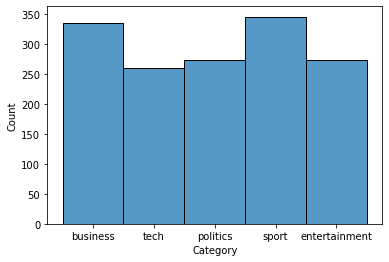

In [10]:
sns.histplot(train["Category"])

Text is a challenging data source for machine learning algorithms because of its complexity and lack of structure. The problem of converting text articles into numerical vectors so that classification models can be applied is very challenging and needs to be done in a way such that:
* Important information of the text is captured
* The codification is efficient (non relevant information is discarded)
* The resultant dimensionality is manageable
* Computation and memory consumption is not an issue

These challanges will be addressed by various preprocessing steps including standarization, puntuation and stopword removal, and the use of Term Frequency - Inverse Document Frequency vectorization.

Delete punctuation signs and transform into lowercase

In [11]:
train["Text"] = train["Text"].apply(
    lambda x: "".join([s.lower() for s in x if s not in string.punctuation])
)
test["Text"] = test["Text"].apply(
    lambda x: "".join([s for s in x if s not in string.punctuation])
)

Tockenization

In [12]:
train["Text"] = train["Text"].apply(lambda x: x.split(" "))
test["Text"] = test["Text"].apply(lambda x: x.split(" "))

Delete stopwords

In [13]:
#nltk.download('stopwords')

In [14]:
stopwords = nltk.corpus.stopwords.words("english")

In [15]:
stopwords = ["".join([s for s in w if s not in string.punctuation]) for w in stopwords]

In [16]:
train["Text"] = train["Text"].apply(lambda t: [w for w in t if w not in stopwords])
test["Text"] = test["Text"].apply(lambda t: [w for w in t if w not in stopwords])

Lenght of text attribute

In [17]:
train["length"] = train["Text"].apply(len)

In [18]:
test["length"] = test["Text"].apply(len)

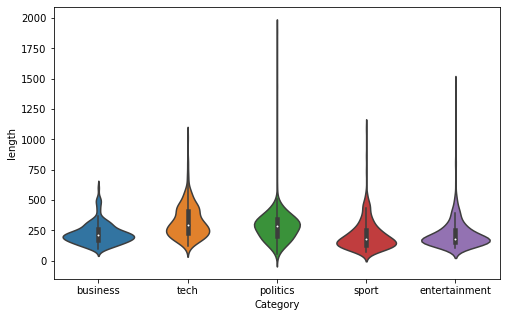

In [19]:
sns.violinplot(data=train, y="length", x="Category")
fig = plt.gcf()
fig.set_size_inches(8, 5)

In [20]:
classes = train["Category"].unique()

Train and test split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    train.drop("Category", axis=1), train["Category"], test_size=0.25
)

The final step to prepare the articles for the machine learning algorithms is to use the TfIdf vectorization. This technique produces a vector $v=\lambda(v_1,v_2,\dots ,v_n)$ for each article where each entry attempts to represent the importance of a specific term in the text and is calculated according to the next formula (there are other similar definitions with subtle differences):
$$
v_i = TF*IDF = \text{Number of appereances of word }i*log\Big(\frac{\text{Number of documents}+1}{\text{Number of documents were word }i\text{ appears}+1}+1\Big)
$$
The left side of the multiplication is bigger as the prevalence of the word increases and the right side of the weights more heavily rare terms. Finally, the $\lambda$ parameter normalizes the vector to norm 1 so that all outputs have the same l2 length.

In [22]:
vectorizer = TfidfVectorizer()

In [23]:
x_train_vectorized = np.array(
    vectorizer.fit_transform(x_train["Text"].apply(lambda x: " ".join(x))).todense()
)

In [24]:
x_test_vectorized = np.array(
    vectorizer.transform(x_test["Text"].apply(lambda x: " ".join(x))).todense()
)


In [25]:
x_test_kaggle = np.array(
    vectorizer.transform(test["Text"].apply(lambda x: " ".join(x))).todense()
)


Now that we have a vectorized representation of the articles let's use matrix factorization for dimensionality reduction in order to visualize the different texts and their respective labels

In [26]:
sklearn_svd = TruncatedSVD(n_components=2)

In [27]:
x_train_2d = sklearn_svd.fit_transform(x_train_vectorized)

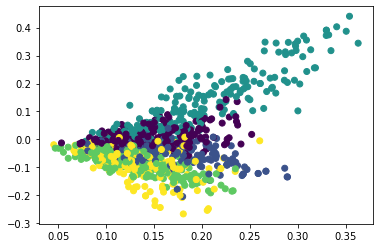

In [28]:
fig, ax = plt.subplots()
ax.scatter(
    x_train_2d[:, 0],
    x_train_2d[:, 1],
    c=y_train.apply(lambda x: list(classes).index(x)),
)

The plot above shows a 2D representation of the articles and their labels, and exposes that there are considerable differences between the different classes.

### Baseline model

Now let's construct a baseline classification model using the K Nearest Neighbors algorithm.

In [29]:
knn = KNeighborsClassifier()

In [30]:
knn_gridcv = GridSearchCV(knn, param_grid={"n_neighbors": N_NEIGH_LIST},)

Cross validation

In [31]:
knn_gridcv.fit(x_train_vectorized, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 22, 25, 27, 30,
                                         35, 40, 50, 75, 100, 150, 200]})

In [32]:
knn = knn_gridcv.best_estimator_
knn_gridcv.best_estimator_

KNeighborsClassifier(n_neighbors=40)

In [33]:
knn_gridcv.best_score_

0.9453955797565662

Test metrics

In [34]:
y_test_pred = knn.predict(x_test_vectorized)

In [35]:
y_test_pred_proba = knn.predict_proba(x_test_vectorized)

In [36]:
accuracy_score(y_test, y_test_pred)

0.967828418230563

The train and test accuracy, and the following ROC plots, reveal that the KNN model has strong predictive power and extrapolates well to unseen data.

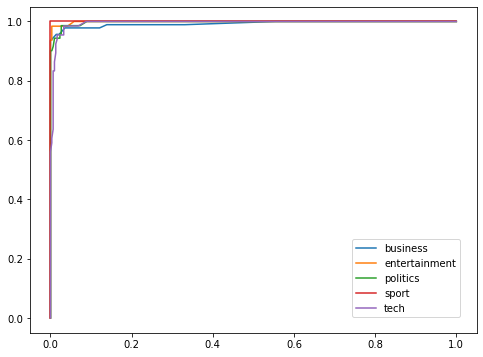

In [37]:
fig, ax = plt.subplots()
for i in range(len(knn.classes_)):
    fpr, tpr, _ = roc_curve(
        (y_test == knn.classes_[i]).astype(int), y_test_pred_proba[:, i]
    )
    ax.plot(fpr, tpr)
fig.legend(labels=knn.classes_, loc=4, bbox_to_anchor=(0.88, 0.15))
fig.set_size_inches(8, 6)

### Non negative matrix factorization

The course assignment requires to test matrix factorization as an unsupervised approach for the classification problem, so the TruncatedSVD class of sklearn will be used to extract 5 features from the texts. Every data instance is then assigned to feature of greater value and then, each of these 5 features will be assigned to a data label by maximizing the accuracy on the training set over all feature permutations. 

In [45]:
sklearn_svd = TruncatedSVD(n_components=5)

In [46]:
pred_train_svd = np.argmax(sklearn_svd.fit_transform(x_train_vectorized), axis=1)

In [47]:
pred_test_svd = np.argmax(sklearn_svd.transform(x_test_vectorized), axis=1)

Finds best permutation for labels

In [48]:
perm_final = None
acc_final = 0
for p in permutations(classes):
    pred_train_svd_label = [p[i] for i in pred_train_svd]
    acc_score = accuracy_score(y_train.values, pred_train_svd_label)
    if acc_score > acc_final:
        perm_final = p
        acc_final = acc_score

In [49]:
perm_final

('sport', 'politics', 'tech', 'entertainment', 'business')

Final metrics over train and test set

In [50]:
acc_final

0.4341987466427932

In [51]:
pred_test_svd_label = [perm_final[i] for i in pred_test_svd]
accuracy_score(y_test.values, pred_test_svd_label)

0.4075067024128686

The resulting accuracies show that the model has some predictive power, as random choice would result in 20% accuracy, but is far worse than the baseline model previously fitted

Now let's use matrix factorization as preprocessing step for dimensionality reduction. In this case this might be very valuable as TfIdf vectorization produces vectors with the same length as the vocaculary. In order to test this procedure let's try cross validating jointly the dimension of the matrix factorization and the K for the KNN.

In [52]:
res_table = pd.DataFrame(columns=["k", "score", "time_train"])

In [53]:
knn_mf = KNeighborsClassifier()
max_acc = 0
knn_best = None
svd_best = None
for n_comp in list(range(2, 25)) + [27, 30, 35, 40, 50, 75, 100, 150, 200, 300]:
    t0 = time.time_ns()
    sklearn_svd = TruncatedSVD(n_components=n_comp)
    x_train_vectorized_mf = sklearn_svd.fit_transform(x_train_vectorized)
    knn_gridcv = GridSearchCV(knn_mf, param_grid={"n_neighbors": N_NEIGH_LIST},)
    knn_gridcv.fit(x_train_vectorized_mf, y_train)
    score = knn_gridcv.best_score_
    t1 = time.time_ns()
    res_table.loc[n_comp] = [
        knn_gridcv.best_estimator_.n_neighbors,
        score,
        (t1 - t0) / 1000000,
    ]
    if score > max_acc:
        max_acc = score
        knn_best = knn_gridcv.best_estimator_
        svd_best = sklearn_svd

In [55]:
res_table.reset_index().rename({'index':'dimension'},axis=1)

,dimension,k,score,time_train
0,2,40.0,0.614102,992.130
1,3,13.0,0.785983,1010.788
2,4,11.0,0.875557,1042.934
3,5,5.0,0.929272,1092.037
4,6,9.0,0.940010,1159.170
5,7,5.0,0.940911,1210.689
6,8,9.0,0.946284,1205.979
7,9,5.0,0.937320,1306.765
8,10,3.0,0.942717,1292.494
9,11,3.0,0.948070,1378.173


Best model

In [56]:
x_train_vectorized_mf = svd_best.fit_transform(x_train_vectorized)
x_test_vectorized_mf = svd_best.transform(x_test_vectorized)

In [71]:
x_test_kaggle_mf = svd_best.transform(x_test_kaggle)

In [62]:
svd_best

TruncatedSVD(n_components=21)

In [57]:
knn_best.fit(x_train_vectorized_mf, y_train)

KNeighborsClassifier(n_neighbors=7)

In [63]:
y_train_pred = knn_best.predict(x_train_vectorized_mf)

In [58]:
y_test_pred = knn_best.predict(x_test_vectorized_mf)

In [64]:
y_test_pred_proba = knn_best.predict_proba(x_test_vectorized_mf)

In [59]:
accuracy_score(y_test, y_test_pred)

0.9705093833780161

The process outputs a model that achieves a better accuracy than the baseline model and that is also considerably simpler and more efficient regarding computation and memory because of the dimensionality reduction.

### Final model and submission

In [69]:
print(
    f"""Final model: 
    Train accuracy  - {accuracy_score(y_train,y_train_pred):.2%}
    Test accuracy   - {accuracy_score(y_test, y_test_pred):.2%}
    Input dimension - {knn_best.n_features_in_}
    K               - {knn_best.n_neighbors}
    """
)

Final model: 
    Train accuracy  - 96.24%
    Test accuracy   - 97.05%
    Input dimension - 21
    K               - 7
    


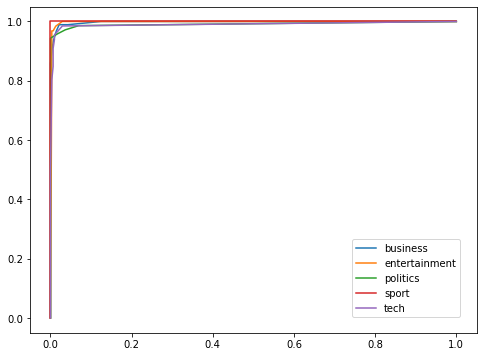

In [70]:
fig, ax = plt.subplots()
for i in range(len(knn.classes_)):
    fpr, tpr, _ = roc_curve(
        (y_test == knn_best.classes_[i]).astype(int), y_test_pred_proba[:, i]
    )
    ax.plot(fpr, tpr)
fig.legend(labels=knn_best.classes_, loc=4, bbox_to_anchor=(0.88, 0.15))
fig.set_size_inches(8, 6)

In [76]:
submission = test[['ArticleId']].copy()

In [77]:
submission['Category'] = knn_best.predict(x_test_kaggle_mf)

In [79]:
submission.to_csv('submission.csv', index=False)

### Conclusions

* Text data requires strong processing in order to achieve useful vector representations
* Matrix factorization is useful for dimensionality reduction
* Other models could be tested in order to improve accuracy

### References

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/